# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd 

# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree



# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_no_ck_mixed_actions import rwm_smooth_biaised_selective_learning


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 6
TRUE_FEEDBACK_STD = 0.175#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

No = N_FEEDBACK_OUTCOMES
Ns = N_LATENT_STATES

# Depending on the dimensions of the problem :
models_constants = {
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    }
}
my_agent = partial(rwm_smooth_biaised_selective_learning,constants= models_constants)

Behaviour of one static biais agent with uniform biais :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
(Array([0., 0., 0.], dtype=float32), Array([0.00049513, 0.00105834, 0.00049513], dtype=float32), Array([0.00072129, 0.00154489, 0.00074269], dtype=float32), Array([0.000582  , 0.00128019, 0.00062216], dtype=float32), Array([0.00051235, 0.0011598 , 0.00056189], dtype=float32), Array([0.00047753, 0.00111146, 0.00053176], dtype=float32), Array([0.00441217, 0.00552893, 0.00198245], dtype=float32), Array([0.00625535, 0.00754205, 0.00244428], dtype=float32), Array([0.00808767, 0.01042324, 0.00381334], dtype=float32), Array([0.00806401, 0.01197485, 0.00428867], dtype=float32), Array([0.0080508 , 0.01274221, 0.00452634], dtype=float32))
(Array([0.02549261, 0.01283598, 0.00581984], dtype=float32), Array([0.03158249, 0.0132237 , 0.00535997], dtype=float32), Array([0.03455933, 0.01400935, 0.00575453], dtype=float32), Array([0.036

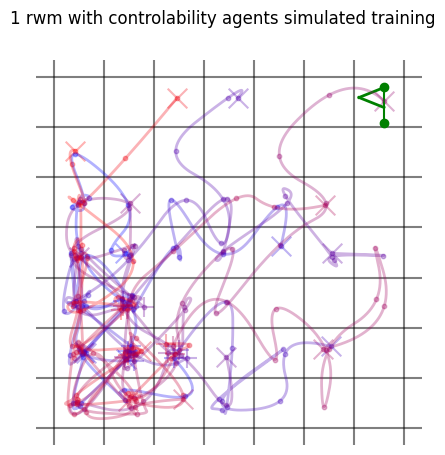

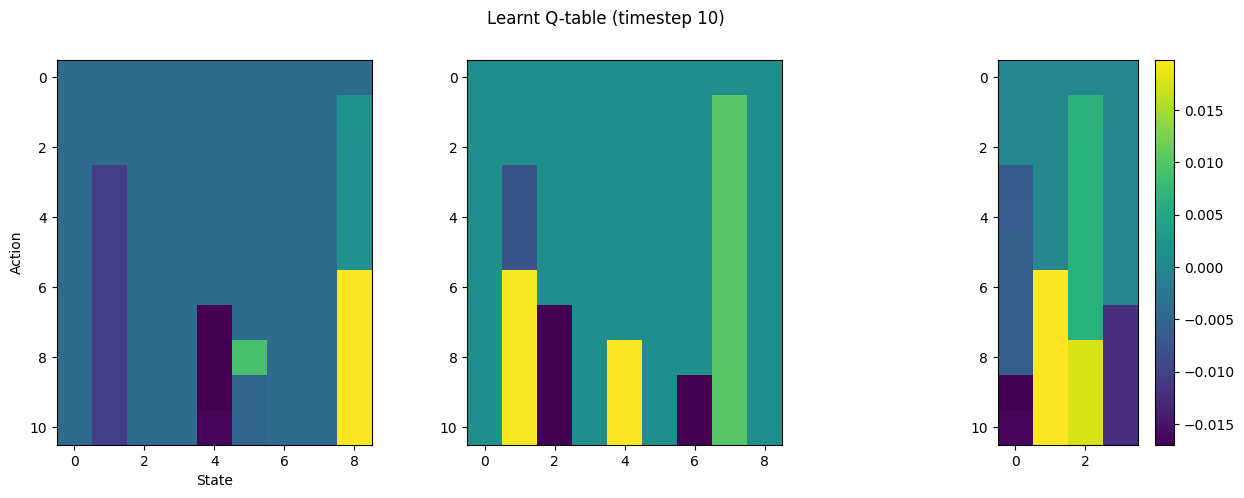

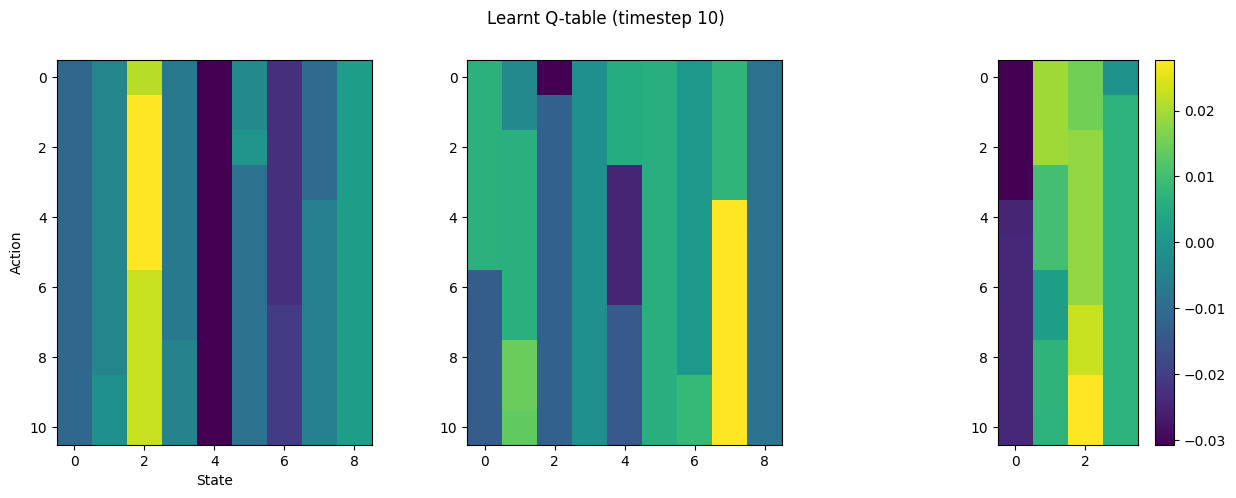

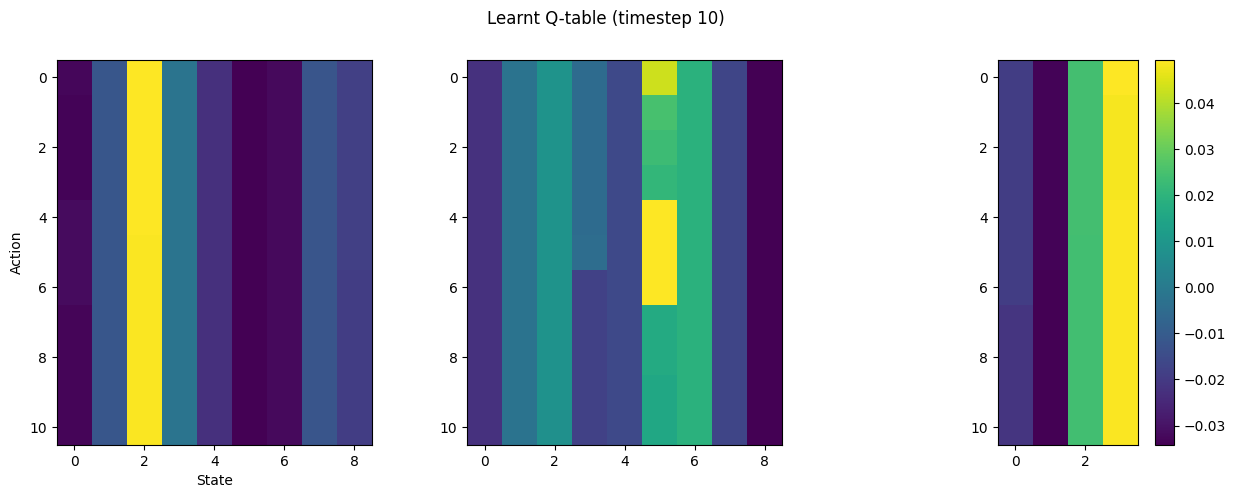

In [10]:
NTRIALS = 20
T = 11
test_run_hparams = {
    "alpha_omega" : 0.5,
    "beta_omega" : 50.0,
    "angle":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 0.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 0.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
    "distance":{
        "biais":_normalize(jnp.array([0.4,0.3,0.0,0.3]))[0],
        "beta_biais" : 0.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
}


SEED = np.random.randint(1000)
params_final,training_hist = run_loop(ENVIRONMENT,my_agent(test_run_hparams),SEED,NTRIALS)
simulated_states = np.array(training_hist["env_states"])

fig,ax = plt.subplots(figsize= (5,5))
fig.suptitle("1 rwm with controlability agents simulated training")
plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


for trial in [0,5,-1]:
    (new_qt,omegas,vect_action_selected) = training_hist["states"][trial]
    # print(np.stack(new_qt["angle"]).shape)
    
    print(omegas)
    
    t = 10
    
    
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle("Learnt Q-table (timestep {})".format(t))
    
    ax = axs[0]
    one_training_episode_qtables = np.stack(new_qt["angle"])
    im = ax.imshow(one_training_episode_qtables,cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    ax.set_xlabel("State")
    ax.set_ylabel("Action")
    
    ax = axs[1]
    one_training_episode_qtables = np.stack(new_qt["position"])
    im = ax.imshow(one_training_episode_qtables,cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    
    ax = axs[2]
    one_training_episode_qtables = np.stack(new_qt["distance"])
    im = ax.imshow(one_training_episode_qtables,cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    
    fig.colorbar(im)


# print(training_hist["states"][1][0])
# print(training_hist["states"][1][1])
# fig,ax = plt.subplots(figsize=(15,5))
# print(omegas.shape)
# ax.imshow(omegas)

Example of behaviour simulated by a given model in the environment :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


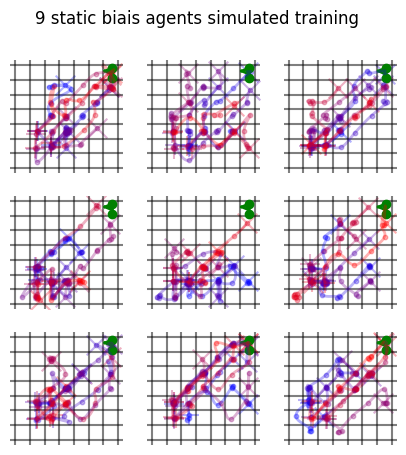

In [12]:
# We can encode static biases for a specific action modality using this model. The global temperature parameter
# beta indicates how likley the agent is to shift focus !

NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 static biais agents simulated training")

test_run_hparams = {
    "alpha_omega" : 0.3,
    "beta_omega" : 100.0,
    "angle":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.1,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 10.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 10.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
    "distance":{
        "biais":_normalize(jnp.array([0.4,0.3,0.0,0.3]))[0],
        "beta_biais" : 10.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,my_agent(test_run_hparams),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


Generate some synthetic data for the model we're interested in, for the purpose of inverting it !

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
GT LL : 
{'angle': Array(-803.5674, dtype=float32), 'distance': Array(-334.28665, dtype=float32), 'position': Array(-115.304115, dtype=float32)}
(30, 11, 3)


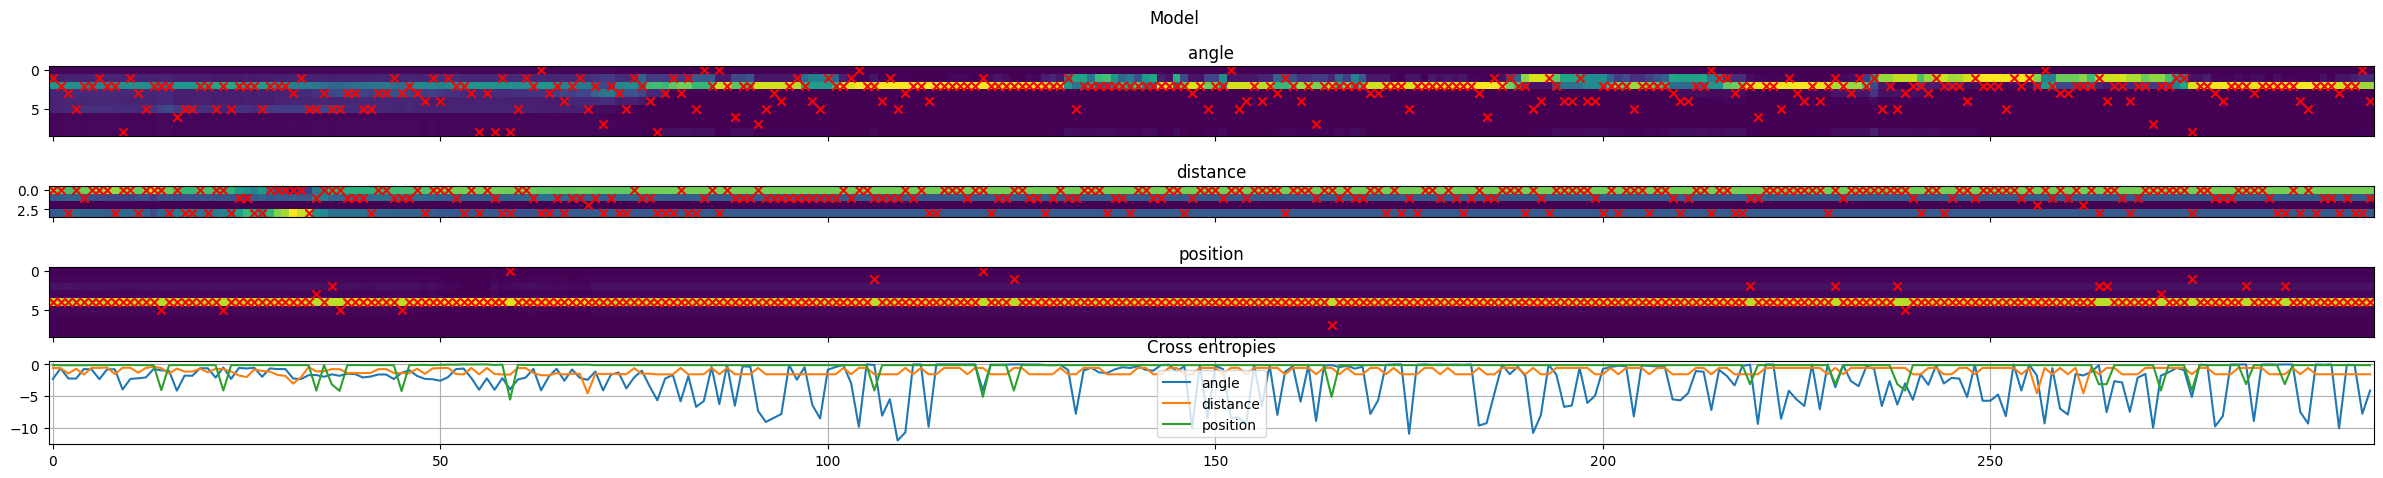

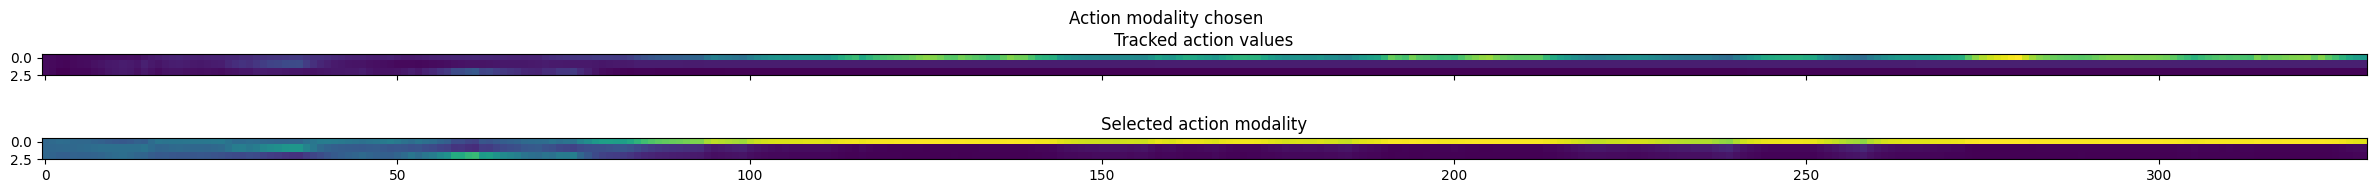

In [13]:
ground_truth_hparams = {
    "alpha_omega" : 0.3,
    "beta_omega" : 100.0,
    "angle":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.1,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 10.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
    "position":{
        "biais":_normalize(jnp.array([0.0,0.1,0.2,0.1,0.5,0.1,0.0,0.0,0.0]))[0],
        "beta_biais" : 10.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
    "distance":{
        "biais":_normalize(jnp.array([0.4,0.3,0.0,0.3]))[0],
        "beta_biais" : 10.0,
        "alpha_Q":0.1,
        "beta_Q" :50.0
    },
}

n_trials = 30
SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,my_agent(ground_truth_hparams),
                                         n_trials=n_trials,seed = 0,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
lls,ces = compute_loglikelihood(SYNTHETIC_DATA,my_agent(ground_truth_hparams),"sum")
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,my_agent(ground_truth_hparams))
model_states,other_data = state_history

# plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(n_trials,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)


omega_values = model_states[1]
print(omega_values.shape)


# print(weight_array.shape)

fig,axs = plt.subplots(2,1,figsize=(n_trials,2),sharex=True)
fig.suptitle("Action modality chosen")
axs[0].set_title("Tracked action values")
axs[0].imshow(np.reshape(omega_values,(-1,3)).T)
axs[1].set_title("Selected action modality")
axs[1].imshow(jax.nn.softmax(50*np.reshape(omega_values,(-1,3)).T,axis=0),vmin=0,vmax=1)


[-8.262985   -9.655018    1.8698263   5.2134037   5.7138133  -3.5550094
  0.20471573  9.275339    5.226381    0.9594226 ]
{'alpha_omega': Array([2.5782149e-04, 6.4098989e-05, 8.6643815e-01, 9.9458635e-01,
       9.9671078e-01, 2.7786925e-02, 5.5100095e-01, 9.9990630e-01,
       9.9465585e-01, 7.2300613e-01], dtype=float32), 'angle': {'alpha_Q': Array([3.2621586e-01, 1.6977246e-01, 5.1670927e-01, 9.9994004e-01,
       3.1841479e-03, 9.5834947e-01, 2.2891783e-03, 9.9253488e-01,
       9.9314159e-01, 3.4289260e-04], dtype=float32), 'beta_Q': Array([5.5068207 , 0.2116473 , 0.5221944 , 0.1739084 , 0.20841709,
       2.9976835 , 2.7089562 , 1.1131305 , 2.7320743 , 6.783706  ],      dtype=float32), 'beta_biais': Array([6.4544353 , 0.55925244, 0.27649975, 0.19490111, 5.9857435 ,
       2.1422088 , 2.2841663 , 0.44929373, 0.26178494, 0.18917939],      dtype=float32), 'biais': Array([[9.91311550e-01, 7.50642482e-09, 1.41168066e-05, 1.35231885e-05,
        1.41549435e-07, 2.25382089e-03, 6.150970

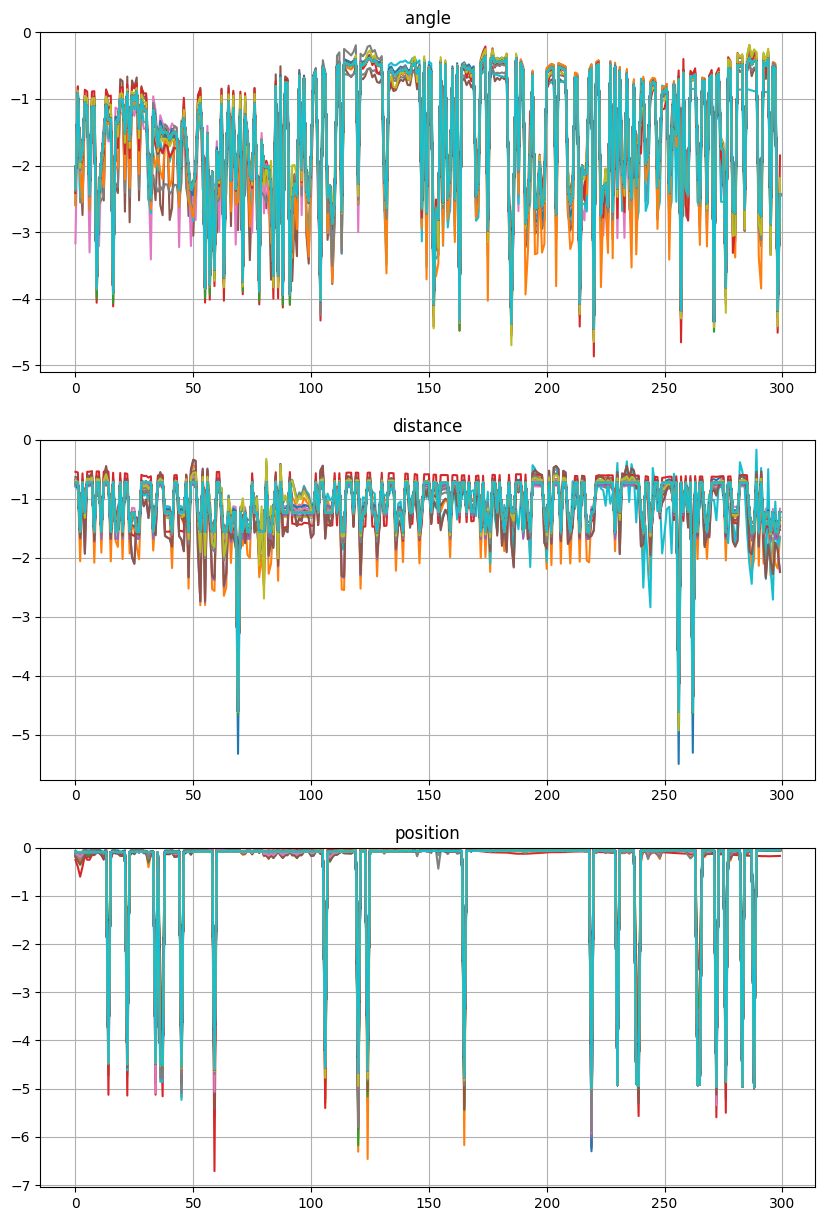

In [ ]:
# Let's attempt the same, but using MAP fitting and ensuring the initial beta parameters are both quite high !


# Assuming uniform distributions for all initial parameter heads :
feature_range_tree ={
    "alpha_omega" : jnp.array([-10,10]),
    "beta_omega" : jnp.array([-2,2]),
    "angle":{
        "biais":jnp.array([-10,10,9]),
        "beta_biais" : jnp.array([-2,2]),
        "alpha_Q": jnp.array([-10,10]),
        "beta_Q" :jnp.array([-2,2])
    },
    "position":{
        "biais":jnp.array([-10,10,9]),
        "beta_biais" : jnp.array([-2,2]),
        "alpha_Q": jnp.array([-10,10]),
        "beta_Q" : jnp.array([-2,2])
    },
    "distance":{
        "biais":jnp.array([-10,10,4]),
        "beta_biais" : jnp.array([-2,2]),
        "alpha_Q": jnp.array([-10,10]),
        "beta_Q" :jnp.array([-2,2])
    }
}


zero_one_uni = tfd.Uniform(low=-1e-5,high=1.0+1e-5)  # Bounds may be a bit finnicky
beta_val = 10
beta_std = 5.0

# Assuming uniform distributions for all initial parameter heads :
parameter_prior_tree ={
    "alpha_omega": zero_one_uni,
    "beta_omega":tfd.Normal(beta_val, beta_std),
    "angle":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
        "beta_biais" : tfd.Normal(beta_val, beta_std),
        "alpha_Q" : zero_one_uni,
        "beta_Q" : tfd.Normal(beta_val, beta_std)
    },
    "position":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
        "beta_biais" : tfd.Normal(beta_val, beta_std),
        "alpha_Q" : zero_one_uni,
        "beta_Q" : tfd.Normal(beta_val, beta_std)
    },
    "distance":{
        "biais" : zero_one_uni,  # No priors on the individual biaises !
        "beta_biais" : tfd.Normal(beta_val, beta_std),
        "alpha_Q" : zero_one_uni,
        "beta_Q" : tfd.Normal(beta_val, beta_std)
    }
}

# all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_map_agent(SYNTHETIC_DATA,
#                             my_agent,feature_range_tree,parameter_prior_tree,jax.random.PRNGKey(0),
#                             n_heads=20,num_steps=250,verbose=True,start_learning_rate=1e-1)

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_mle_agent(SYNTHETIC_DATA,
                            my_agent,feature_range_tree,jax.random.PRNGKey(0),
                            n_heads=20,num_steps=250,verbose=True,start_learning_rate=1e-1)

final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum"))(all_fin_params)


print(cross_entropies["angle"])
print(min(final_lls["angle"]))
print(max(final_lls["angle"]))
fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(100):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0)
    axs[i].grid()
plt.show()

Given the best match for subject parameters, we then reconstruct the evolution of model states / parameters across trials.

(20, 30, 11, 9)
{'alpha_omega': Array([1.0000000e+00, 9.9991179e-01, 9.8004591e-01, 2.9714484e-04,
       3.3047404e-02, 9.9223900e-01, 8.2824556e-03, 2.4767321e-02,
       1.4690590e-01, 6.4269057e-03, 4.9702391e-02, 9.3206310e-01,
       6.9001362e-02, 1.2891636e-02, 5.2174264e-01, 9.9992430e-01,
       3.1012620e-03, 3.2258242e-02, 2.9835170e-02, 1.7822523e-03],      dtype=float32), 'angle': {'alpha_Q': Array([0.1688497 , 0.1694152 , 0.1710631 , 0.14688157, 0.17066957,
       0.71327066, 0.17586015, 0.13376889, 0.17178318, 0.03698386,
       0.1684508 , 0.12249393, 0.17513031, 0.27905363, 0.1710315 ,
       0.1715338 , 0.1714595 , 0.18325363, 0.1706709 , 0.17115897],      dtype=float32), 'beta_Q': Array([ 30.274578,  30.35513 ,  28.509432,  29.87923 ,  30.121174,
         8.888361,  34.219776,  20.485605,  29.349207, 239.24704 ,
        32.953484,  44.095192,  29.985334,   8.441199,  30.130037,
        30.300386,  29.988295,  28.935091,  18.215158,  29.900602],      dtype=float32), 

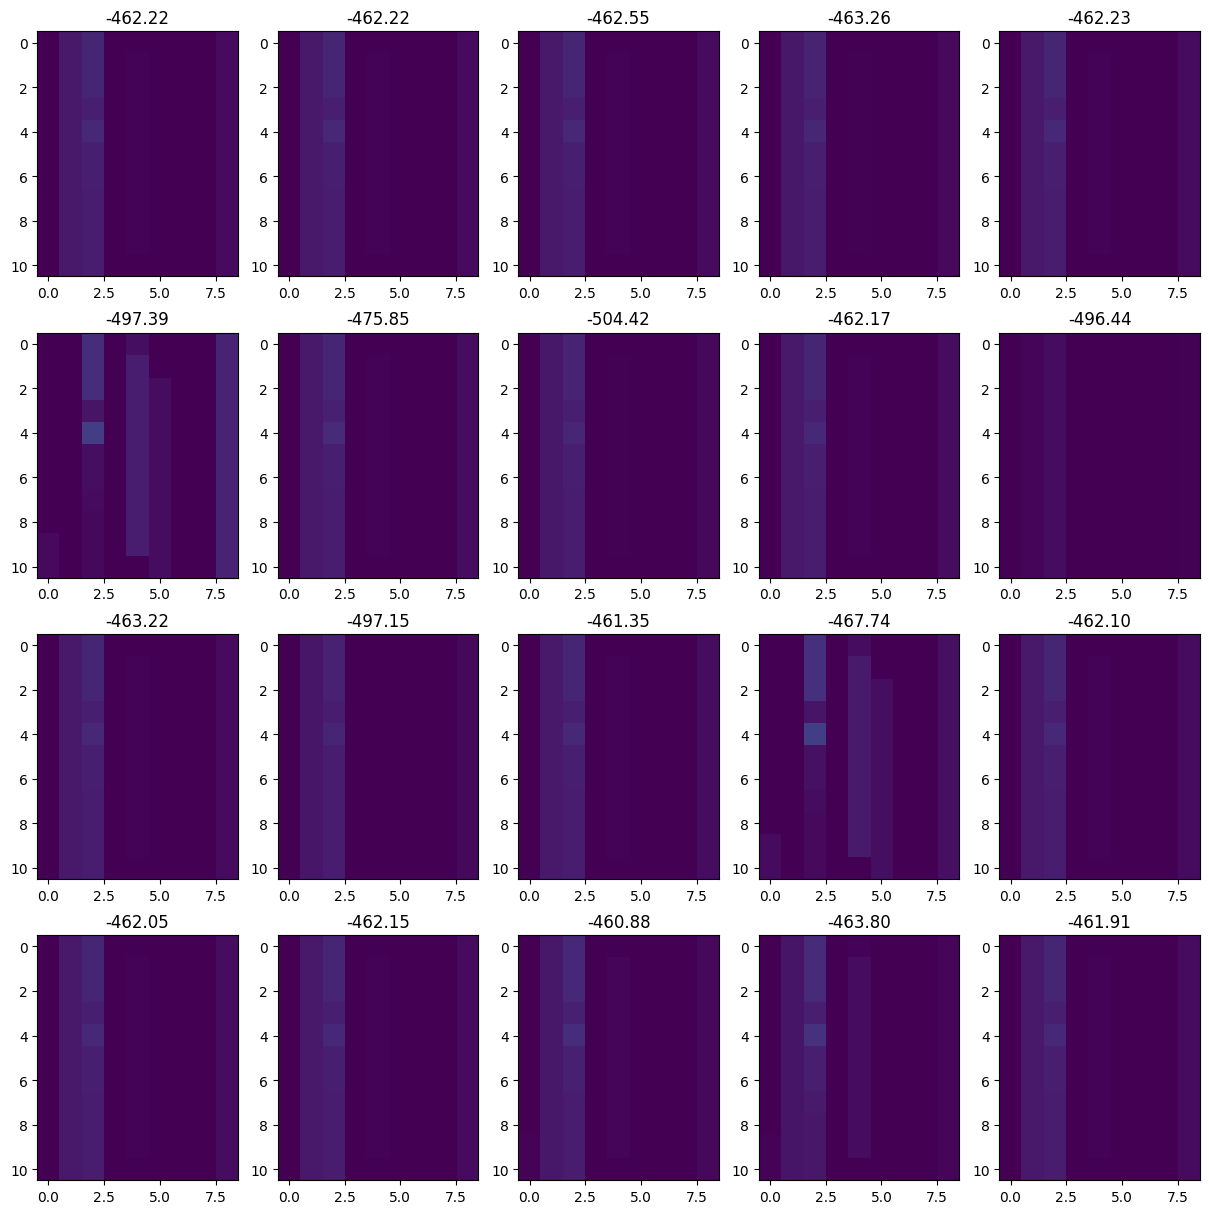

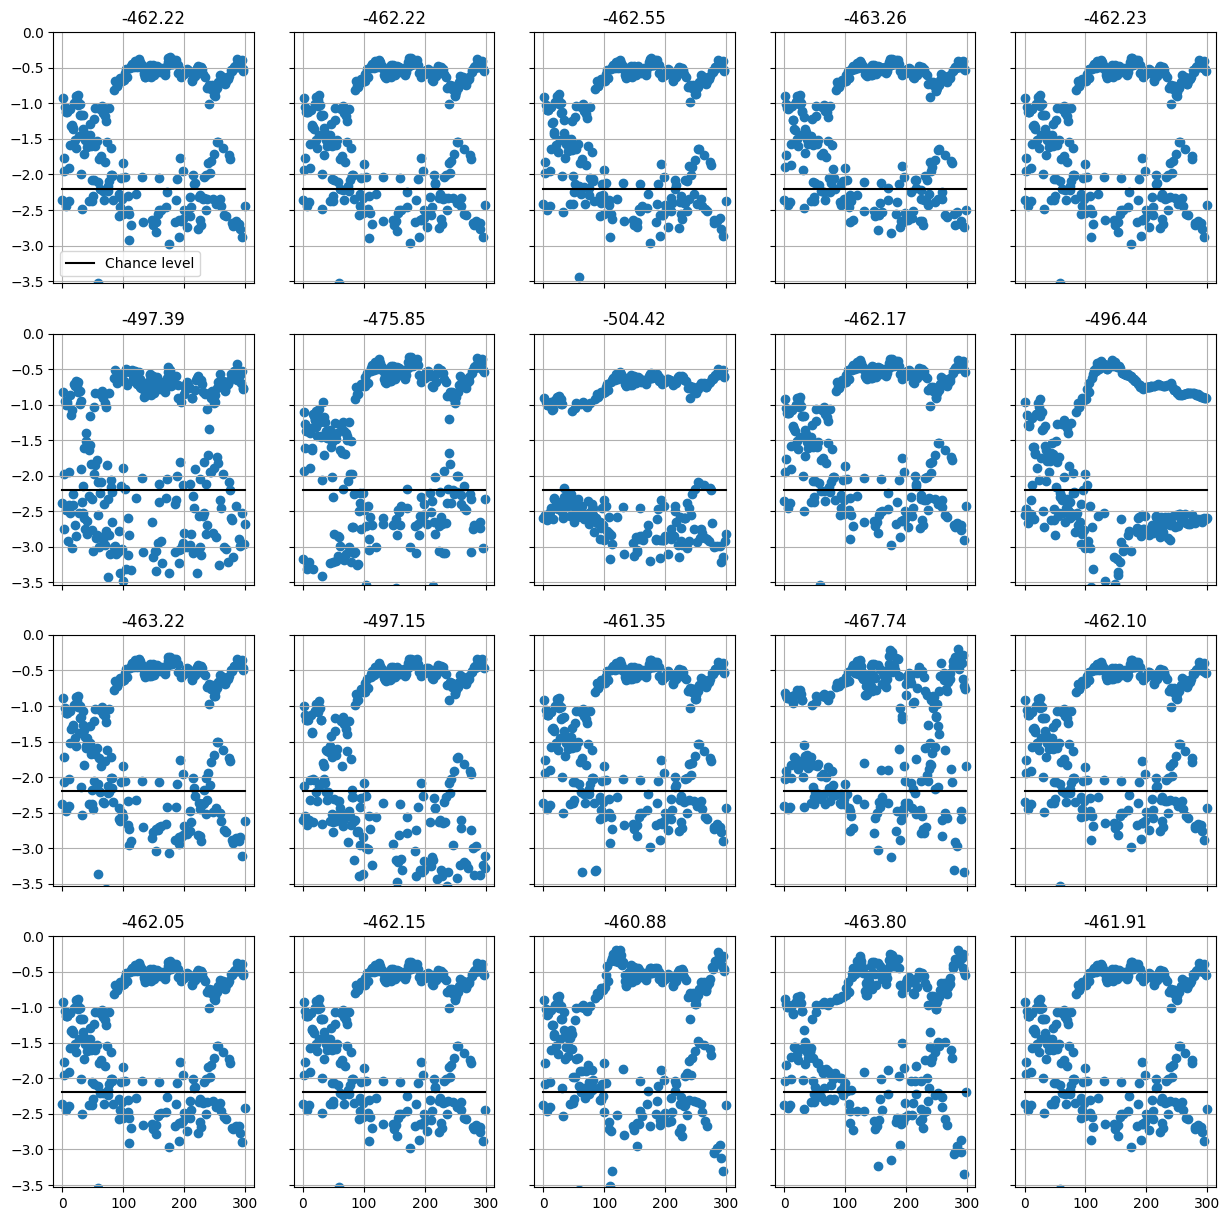

In [15]:
# We will need a random model to evaluate the goodness of our predictions ! 
from agents_no_ck import random_agent

random_ll_term,random_predictions,random_model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,random_agent(encoding_function(x),models_constants),"sum",True))(all_fin_params)
random_logliks,random_cross_entropies = random_ll_term

ll_term,predictions,model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum",True))(all_fin_params)
model_states,other_data = model_variables

logliks,cross_entropies = ll_term
qtable,omegas,_ = model_states



print(qtable["angle"].shape)  # N_heads x N_trials x N_timesteps x (Qtable)



optimal_params = jax.vmap(lambda x : encoding_function(x))(all_fin_params)
print(optimal_params)

# The states of this model are None, so it's not very useful :p
fig,axs = plt.subplots(4,5,figsize=(15,15))
for k,ax in enumerate(axs.flatten()):
    ax.set_title("{:.2f}".format(float(logliks["angle"][k])))
    ax.imshow(qtable["angle"][k,-1,...],vmin=0,vmax=1)
plt.show()


ce_plots = np.reshape(cross_entropies["angle"],(cross_entropies["angle"].shape[0],-1))
random_ce_plots = np.reshape(random_cross_entropies["angle"],(random_cross_entropies["angle"].shape[0],-1))
fig,axs = plt.subplots(4,5,figsize=(15,15),sharex=True,sharey=True)
LOWER_EDGE = np.mean([np.min(ce_plots),np.min(random_ce_plots)])
for k,ax in enumerate(axs.flatten()):
    ax.scatter(np.arange(ce_plots[k].shape[0]),ce_plots[k])
    
    if k == 0:
        ax.plot(random_ce_plots[k],color="black",label="Chance level")
    else:
        ax.plot(random_ce_plots[k],color="black")
    ax.set_ylim([LOWER_EDGE,0])
    ax.grid()
    ax.set_title("{:.2f}".format(float(logliks["angle"][k])))

axs.flatten()[0].legend()
plt.show()


Let's try to probe how good our inversion is for this specific set of parameters :

{'alpha_omega': 0.3, 'beta_omega': 100.0, 'angle_biais': Array([0.        , 0.16666666, 0.3333333 , 0.16666666, 0.16666666,
       0.16666666, 0.        , 0.        , 0.        ], dtype=float32), 'angle_beta_biais': 10.0, 'angle_alpha_Q': 0.1, 'angle_beta_Q': 50.0, 'position_biais': Array([0. , 0.1, 0.2, 0.1, 0.5, 0.1, 0. , 0. , 0. ], dtype=float32), 'position_beta_biais': 10.0, 'position_alpha_Q': 0.1, 'position_beta_Q': 50.0, 'distance_biais': Array([0.4, 0.3, 0. , 0.3], dtype=float32), 'distance_beta_biais': 10.0, 'distance_alpha_Q': 0.1, 'distance_beta_Q': 50.0}


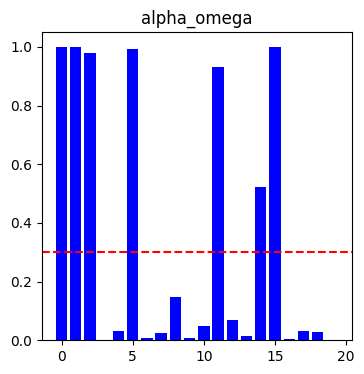

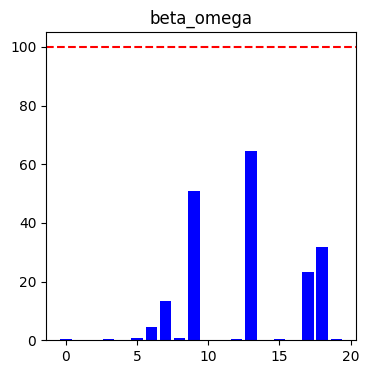

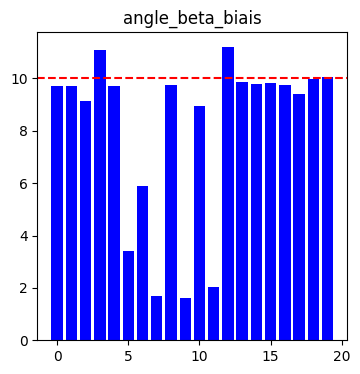

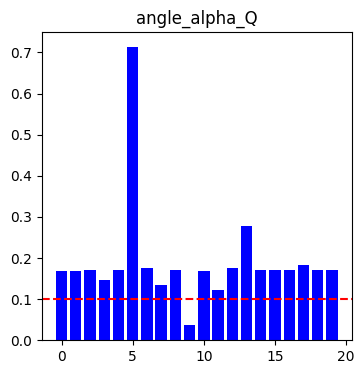

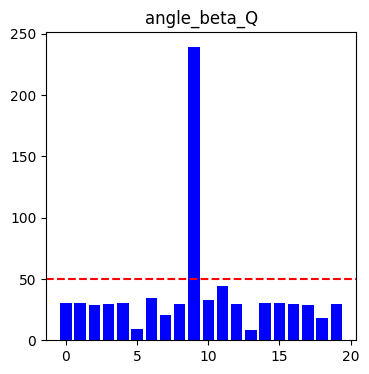

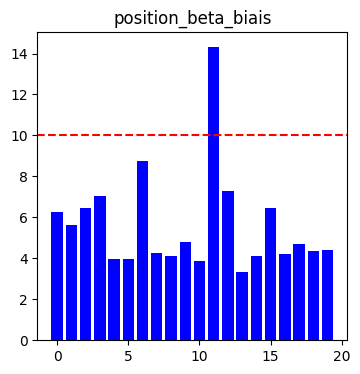

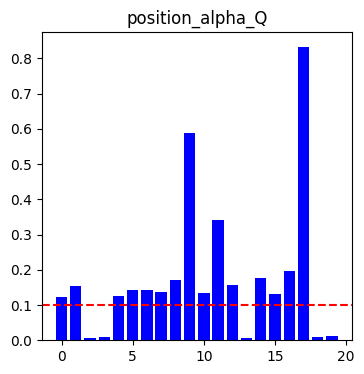

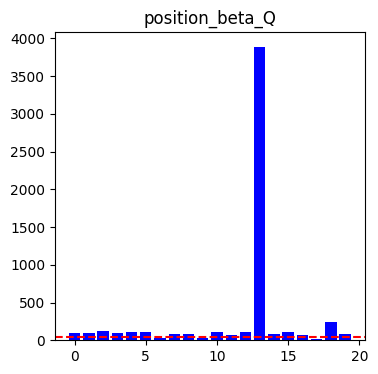

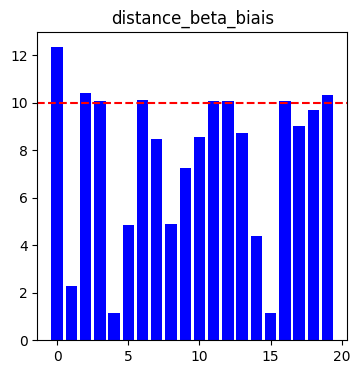

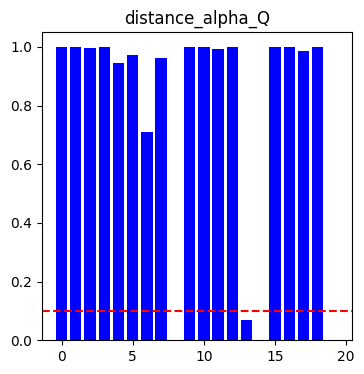

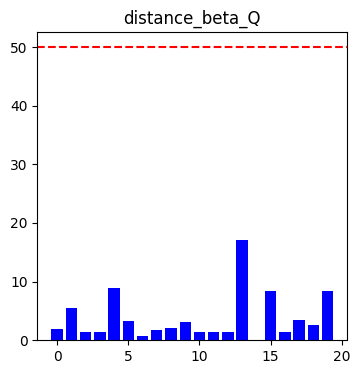

In [16]:
from agents_no_ck import random_agent

random_ll_term,random_predictions,random_model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,random_agent(encoding_function(x),models_constants),"sum",True))(all_fin_params)
random_logliks,random_cross_entropies = random_ll_term

ll_term,predictions,model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,my_agent(encoding_function(x)),"sum",True))(all_fin_params)
model_states,other_data = model_variables

logliks,cross_entropies = ll_term
qtable,omegas,_ = model_states





fitted_params = jax.vmap(lambda x : encoding_function(x))(all_fin_params)
# print(fitted_params["beta_omega"])
# print(ground_truth_hparams)

from collections.abc import MutableMapping
def flatten(dictionary, parent_key='', separator='_'):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

flat_gt = flatten(ground_truth_hparams)
flat_fit = flatten(fitted_params)

print(flat_gt)


key = "beta_Q"

for key,gtvalue in flat_gt.items():
    
    
    if type(gtvalue)==float:
        data_points = flat_fit[key]
        n_points = data_points.shape[0]
        
        fig,ax =  plt.subplots(figsize=(4,4))
        ax.set_title(key)
        ax.bar(range(n_points), data_points, color="blue", label="Data Points")
        ax.axhline(y=gtvalue, color="red", linestyle="--", label="Ground Truth")
    